# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import operator
import time
from sklearn.preprocessing import Imputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA    
from sklearn.preprocessing import LabelEncoder

# magic word for producing visualizations in notebook
%matplotlib inline

**Important Reads**
* Package Operator [Reference](https://docs.python.org/3/library/operator.html)
* Package PPrint [Reference](https://docs.python.org/3/library/pprint.html)

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
try:
    azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')
except:
    print("File not found.")

# Load in the feature summary file.
try:
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')
except:
    print("File not found.")

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
nrows, ncols = azdias.shape
print("Number of rows = {}".format(nrows))
print("Number of columns = {}".format(ncols))
# Print first 10 rows of the dataset
azdias.head(10)

Number of rows = 891221
Number of columns = 85


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [4]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [5]:
# Identify missing or unknown data values and convert them to NaNs.
start = time.time()
# Prepare feat_info via strip and split
# Remove missing_or_unknown codes from azdias
for index in feat_info.index:
    feat_info.loc[index,'missing_or_unknown'] = feat_info.loc[index,'missing_or_unknown'].strip('[]').split(',')
    for item in range(len(feat_info.loc[index,'missing_or_unknown'])):
        try:
            feat_info.loc[index,'missing_or_unknown'][item] = int(feat_info.loc[index,'missing_or_unknown'][item])
        except:
            continue
    azdias.loc[:,(feat_info.loc[index, 'attribute'])].replace(feat_info.loc[index,'missing_or_unknown'], np.nan, inplace=True)
end = time.time()
print("Total execution time of this procedure: {:.2f} seconds".format(end-start))

Total execution time of this procedure: 2.13 seconds


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [6]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_col = azdias.isnull().sum()

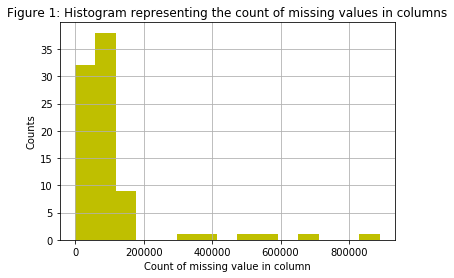

In [7]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(missing_col, bins=15, facecolor='y', alpha=1)
plt.xlabel('Count of missing value in column')
plt.ylabel('Counts')
plt.title('Figure 1: Histogram representing the count of missing values in columns')
plt.grid(True)
plt.show()

**Interpretation:** Figure 1 illustrates the count of missing values in the columns. Notice, there are around 6 columns that contain more than 200000 of missing values and are likely to been seen as Outliers. Before we reach to any conclusion, let's try investigating them. Let's represents each column by it's percentage of missing values.

In [8]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
missing_col_filtered = missing_col[missing_col>200000]
azdias.drop(missing_col_filtered.index, axis=1, inplace=True)

In [9]:
missing_col

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

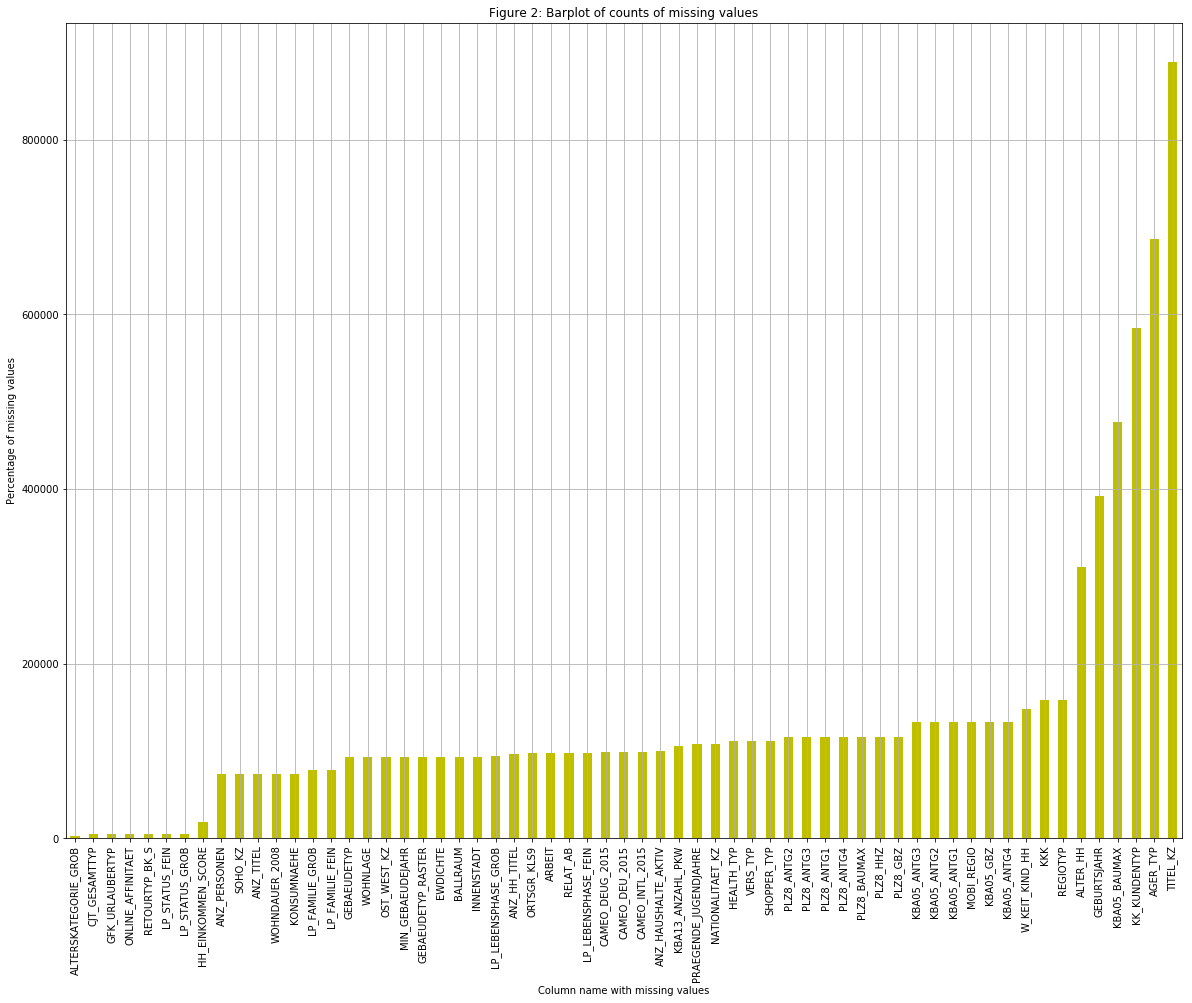

There are 61 columns with missing values.


In [10]:
missing_columns = missing_col[missing_col>0]
missing_columns.sort_values(inplace=True)
missing_columns.plot.bar(figsize=(20,15), facecolor='y')
plt.xlabel('Column name with missing values')
plt.ylabel('Percentage of missing values')
plt.grid(True)
plt.title('Figure 2: Barplot of counts of missing values')
plt.show()
print("There are {} columns with missing values.".format(len(missing_columns)))

**Interpretation**: From Figure 2, we see there are total of 61 columns that contain missing values out of original 85 columns in the dataset. And most of the columns contains missing values in between 0.544% to 25%. Next, we identify the outlier column in the dataset.

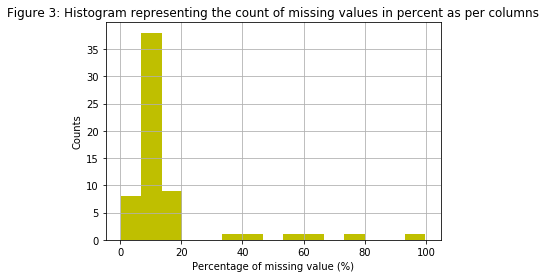

In [11]:
# Assessing those columns that have more than 0 missing values only
plt.hist(((missing_col[missing_col >= 1]/(azdias.shape[0])) * 100), bins=15, facecolor='y', alpha=1)
plt.xlabel('Percentage of missing value (%)')
plt.ylabel('Counts')
plt.title('Figure 3: Histogram representing the count of missing values in percent as per columns')
plt.grid(True)

In [12]:
# Identify and Store the names of the columns containing more than 22% of missing values in variable 'missing_col_filtered'
print(missing_col_filtered)

AGER_TYP        685843
GEBURTSJAHR     392318
TITEL_KZ        889061
ALTER_HH        310267
KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
dtype: int64


**Interpretation:** The columns named as 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX' only seems to have more than 200000 missing values. When compared with the graph above, these columns have missing values ranging from 35% to 99%, so rather than imputing the missing values, it seems suitable to drop the column.

#### Discussion 1.1.2: Assess Missing Data in Each Column

**Conclusion:** Most of the columns in the dataset had missing values which ranged from 0.5446% to 22%. Figure 2 illustrates the count of columns having > 200000 rows which equates to around more than 22% of the missing values in the dataset.
Figure 3 illustrates the percentage distribution of count of missing values, where 7 columns have 0.5% of missing values, and the remaining others have around 1% to 22% missing values. Thus, it's not ideal to replace or impute the columns 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX' with missing values as it may introduce a bias, thus they can be dropped.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

##### Note: We have dropped 6 column out of the original 85 columns in the dataset. Thus we have remaining 79 columns in our dataset.

In [13]:
# Number of rows that contain any missing value in the azdias dataset
print(sum(azdias.isnull().any(axis=1)))

268012


**Comments:** Total of 268012 rows contains 1 or more missing values out of 891221 observations. That means 30% of our observations (rows) have any sort of missing values.

In [14]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
n_missing = azdias.isnull().transpose().sum()
azdias_missing_low = azdias[n_missing<20]
azdias_missing_high = azdias[n_missing>=20];
n_missing_low = azdias_missing_low.isnull().transpose().sum()
n_missing_high = azdias_missing_high.isnull().transpose().sum()

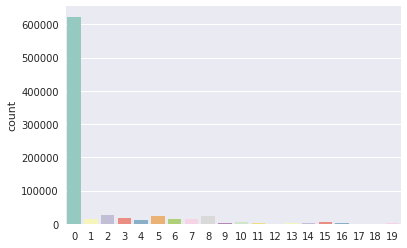

In [15]:
sns.set(style="darkgrid")
sns.countplot(azdias_missing_low.isnull().transpose().sum(),palette="Set3")

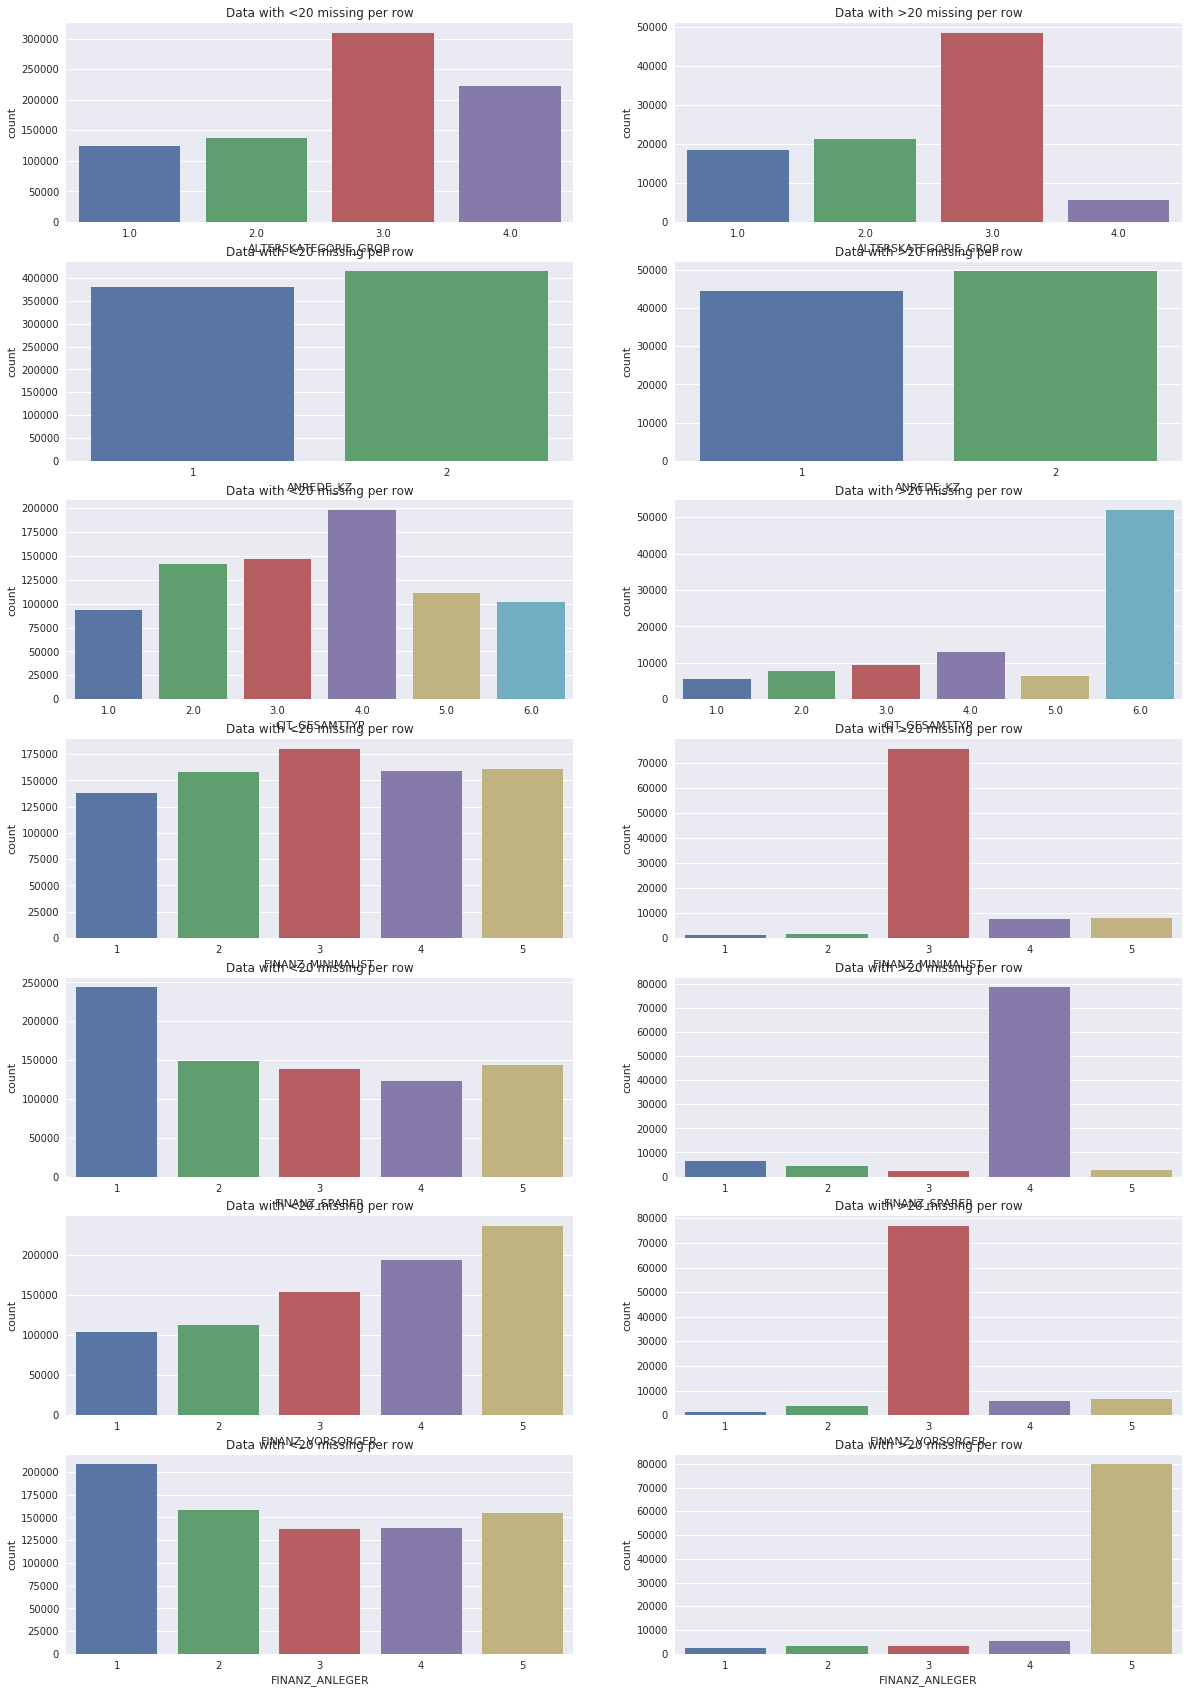

In [16]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(20,30))
n=0
sns.set(style="darkgrid")
for column in azdias.columns[0:7]:
    sns.countplot(azdias_missing_low.loc[:, column], ax=axes[n,0])
    axes[n,0].set_title('Data with <20 missing per row')
    sns.countplot(azdias_missing_high.loc[:, column], ax=axes[n,1])
    axes[n,1].set_title('Data with >20 missing per row')
    n+=1

Graph Visualization [Reference](https://github.com/denizn)

In [17]:
azdias_missing_low.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


#### Discussion 1.1.3: Assess Missing Data in Each Row

When comparing the results of total number of rows containing 1 or more missing values with total number of total observations (rows) we find that around 30% of data has 1 or more missing values. Around 96429 rows out of 891221 i.e. around 10.8% contain more than 25% ((20/79)x100) missing values in each row.

Options to manage with missing values:

1) Drop all the columns that have missing values which means 55 columns being dropped after dropping {'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'}initially as referred from Figure 2 leaving us with only 24 columns out of 79 columns.

2) Drop all rows that contain all missing values which means dropping 30% of our data.

3) Trying to impute the missing values in rows with the mode since mode is least affected by outliers in contrast to mean or median.

From the graphs above there are quite a few columns with similar distributions across rows within the two groups based on missing values per row, so it would be safe to say that data with lots of missing values are qualitatively different overall from the data with few or no missing values. I will be proceeding my analysis with rows with missing value count of less than 20. So, opting with **3rd** choice seems to be most suitable approach.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [18]:
# How many features are there of each data type?
feat_info.groupby('type').count()

,attribute,information_level,missing_or_unknown
type,,,
categorical,21,21,21
interval,1,1,1
mixed,7,7,7
numeric,7,7,7
ordinal,49,49,49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [19]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [20]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical = feat_info[feat_info['type'] == 'categorical']['attribute'].values
categorical = [x for x in categorical if x in azdias.columns] # only the ones that are kept in azdias dataset
binary = [x for x in categorical if azdias[x].nunique()==2]
multilevel = [x for x in categorical if azdias[x].nunique()>2]
azdias[categorical].nunique()

ANREDE_KZ            2
CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
GREEN_AVANTGARDE     2
LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB      5
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
NATIONALITAET_KZ     3
SHOPPER_TYP          4
SOHO_KZ              2
VERS_TYP             2
ZABEOTYP             6
GEBAEUDETYP          7
OST_WEST_KZ          2
CAMEO_DEUG_2015      9
CAMEO_DEU_2015      44
dtype: int64

In [21]:
azdias[categorical].nunique().sum()

138

In [22]:
# Import package that filters out warning messages
import warnings
warnings.filterwarnings("ignore")

In [23]:
# Drop CAMEO DEU_2015 which has 44 features which is too granular for a single column.
multilevel.remove('CAMEO_DEU_2015')
azdias_missing_low.drop('CAMEO_DEU_2015', axis=1, inplace=True)

In [24]:
# Step 1: Convert binary variable with non-numeric values into a binary variable with numeric values
azdias_missing_low.loc[:, 'OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True);

In [25]:
azdias_missing_low.columns.shape

(78,)

In [26]:
# Display multilevel after changes made in above step
print(multilevel)

# Step 2: Convert multi-level categoricals into dummy variables
for col in multilevel:
    dat = azdias_missing_low[col][azdias_missing_low[col].notnull()]
    dummies = pd.get_dummies(dat, prefix=col)
    azdias_missing_low = azdias_missing_low.join(dummies)
    azdias_missing_low.drop([col], axis=1, inplace=True)

['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015']


#### Discussion 1.2.1: Re-Encode Categorical Features

We had decided to retain all categorical features except 'CAMEO_DEU_2015' since 44 differrent levels of this features will result in 44 dummy variables alone and thus will explain very less information. So, after that we converted the sole non-numeric binary variable 'OST_WEST_KZ' into a numeric binary variable replacing 'W' with 0 and 'O' with 1. Then for every multi-level caegorical variable, we did one-hot encoding or dummy variables (n-1 features) using pd.get_dummies.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [27]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
mixed = feat_info[feat_info['type'] == 'mixed']['attribute'].values
mixed = [x for x in mixed if x in azdias_missing_low.columns] # only the ones that are kept in azdias_lowmiss dataset

# Extract variable MAINSTREAM from PRAEGENDE_JUGENDJAHRE
mainstream = [1, 3, 5, 8, 10, 12, 14]
avantgarde = [2, 4, 6, 7, 9, 11, 13, 15]
def mstream(x):
    if x in mainstream:
        return 1
    elif x in avantgarde:
        return 0
    else:
        return x

azdias_missing_low['PRAEGENDE_JUGENDJAHRE_MAINSTREAM'] = azdias_missing_low['PRAEGENDE_JUGENDJAHRE'].apply(mstream)

# Create variable mapping 'decade' and map it to PRAEGENDE_JUGENDJAHRE, creating a new binary feature
x = [x+1 for x in range(15)]
y = [40, 40, 50, 50, 60, 60, 60, 70, 70, 80, 80, 80, 80, 90, 90]
decade = pd.Series(y, index = x)
azdias_missing_low['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias_missing_low['PRAEGENDE_JUGENDJAHRE'].map(decade)

In [28]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_missing_low.loc[azdias_missing_low['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015_WEALTH'] = azdias_missing_low.loc[azdias_missing_low['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015'].map(lambda x:int(str(x)[0]))
azdias_missing_low.loc[azdias_missing_low['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015_LIFESTAGE'] = azdias_missing_low.loc[azdias_missing_low['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015'].map(lambda x:int(str(x)[1]))

# Remove all mixed variables
azdias_missing_low.drop(mixed, axis=1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

In the intial step we had split two of the mixed-type features PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 into two features each. LP_LEBENSPHASE_FINE was removed from the data because of the 40 levels it had. In my opinion this is too granular and LP_LEBENSPHASE_GROB should suffice.

It was suitable to keep all mixed categorical variables except LP_LEBENSPHASE_FINE and thus applied One Hot Encoding / Dummy Variable to those I kept as a final step.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [29]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')
    for index in feat_info.index:
        feat_info.loc[index,'missing_or_unknown'] = feat_info.loc[index,'missing_or_unknown'].strip('[]').split(',')
        for item in range(len(feat_info.loc[index,'missing_or_unknown'])):
            try:
                feat_info.loc[index,'missing_or_unknown'][item] = int(feat_info.loc[index,'missing_or_unknown'][item])
            except:
                continue
        df.loc[:,(feat_info.loc[index, 'attribute'])].replace(feat_info.loc[index,'missing_or_unknown'], np.nan, inplace=True)
            
    # remove selected columns and rows, ...
        # remove columns previously removed
    df.drop(missing_col_filtered.index , axis=1, inplace=True)
        # remove rows > 20 missing values
    n_missing = df.isnull().transpose().sum()
    df_lowmiss = df[n_missing<20]
    
    # select, re-encode, and engineer column values.
    categorical = feat_info[feat_info['type'] == 'categorical']['attribute'].values
    categorical = [x for x in categorical if x in df_lowmiss.columns] # only the ones that are kept in df dataset
    binary = [x for x in categorical if df_lowmiss[x].nunique()==2]
    multilevel = [x for x in categorical if df_lowmiss[x].nunique()>2]
    
    multilevel.remove('CAMEO_DEU_2015')
    df_lowmiss.drop('CAMEO_DEU_2015', axis=1, inplace=True) # Drop CAMEO_DEU_2015 due to too much detail
    
    df_lowmiss.loc[:, 'OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True); # Convert OST_WEST_KZ into binary categorical
    
         #onehotencode multilevel
    for col in multilevel:
        dat = df_lowmiss[col][df_lowmiss[col].notnull()]
        dummies = pd.get_dummies(dat, prefix=col)
        df_lowmiss = df_lowmiss.join(dummies)
        df_lowmiss.drop([col], axis=1, inplace=True)
    
        # Extract variable MAINSTREAM from PRAEGENDE_JUGENDJAHRE
    mainstream = [1, 3, 5, 8, 10, 12, 14]
    avantgarde = [2, 4, 6, 7, 9, 11, 13, 15]

    df_lowmiss['PRAEGENDE_JUGENDJAHRE_MAINSTREAM'] = df_lowmiss['PRAEGENDE_JUGENDJAHRE'].apply(mstream)

        # Create variable mapping 'decade' and map it to PRAEGENDE_JUGENDJAHRE, creating a new feature
    x = [x+1 for x in range(15)]
    y = [40, 40, 50, 50, 60, 60, 60, 70, 70, 80, 80, 80, 80, 90, 90]
    decade = pd.Series(y, index = x)
    df_lowmiss['PRAEGENDE_JUGENDJAHRE_DECADE'] = df_lowmiss['PRAEGENDE_JUGENDJAHRE'].map(decade)
    
        # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    df_lowmiss.loc[df_lowmiss['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015_WEALTH'] = df_lowmiss.loc[df_lowmiss['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015'].map(lambda x:int(str(x)[0]))
    df_lowmiss.loc[df_lowmiss['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015_LIFESTAGE'] = df_lowmiss.loc[df_lowmiss['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015'].map(lambda x:int(str(x)[1]))

        # Remove all mixed columns and LP_LEBENSPHASE_FINE which I found to be too granular to work with (40 different values)
   
        # Drop mixed columns
    mixed = feat_info[feat_info['type'] == 'mixed']['attribute'].values
    mixed = [x for x in mixed if x in df_lowmiss.columns] # only the ones that are kept in df_lowmiss dataset
    df_lowmiss.drop(mixed, axis=1, inplace=True) # drop mixed features for complexity reduction

        # Convert mixed features into dummy variables (Decided to ignore)
    #for col in mixed:
        #dat = df_lowmiss[col][df_lowmiss[col].notnull()]
        #dummies = pd.get_dummies(dat, prefix=col)
        #df_lowmiss = df_lowmiss.join(dummies)
        #df_lowmiss.drop([col], axis=1, inplace=True)
        
    # Add columns filled with zero for column wih no data
    columns = [col for col in azdias_missing_low if col not in df_lowmiss]
    for column in columns:
        df_lowmiss[column] = 0
        
    # Return the cleaned dataframe.
    return df_lowmiss

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [30]:
print(azdias_missing_low.shape)

(797077, 148)


In [31]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
imputer = Imputer()
azdias_missing_low = pd.DataFrame(imputer.fit_transform(azdias_missing_low), columns = azdias_missing_low.columns)

In [32]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
azdias_missing_low = pd.DataFrame(scaler.fit_transform(azdias_missing_low), columns = azdias_missing_low.columns)

### Discussion 2.1: Apply Feature Scaling

* We imputed the missing values using Imputer package that replaces the missing value with the mean of the column. [Reference](https://scikit-learn.org/stable/modules/impute.html)
* To bring the data to same scale for comparison we standardized the data using StandardScaler package

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [33]:
# Apply PCA to the data.
pca = PCA()
azdias_pca = pca.fit_transform(azdias_missing_low)

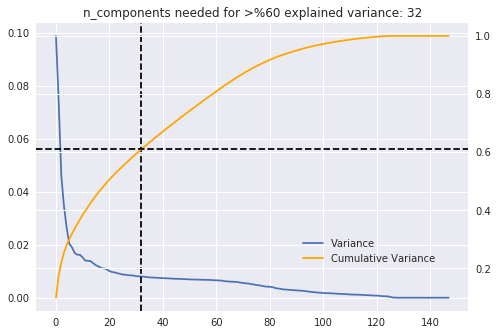

In [34]:
# Investigate the variance accounted for by each principal component.
# Number of components required to maintain %80 variance:
n_components = min(np.where(np.cumsum(pca.explained_variance_ratio_)>0.6)[0]+1)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1],True)
ax2 = ax.twinx()
ax.plot(pca.explained_variance_ratio_, label='Variance',)
ax2.plot(np.cumsum(pca.explained_variance_ratio_), label='Cumulative Variance',color = 'orange');
ax.set_title('n_components needed for >%60 explained variance: {}'.format(n_components));
ax.axvline(n_components, linestyle='dashed', color='black')
ax2.axhline(np.cumsum(pca.explained_variance_ratio_)[n_components], linestyle='dashed', color='black')
fig.legend(loc=(0.6,0.2));


In [35]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=n_components, random_state=10)
azdias_pca = pca.fit_transform(azdias_missing_low)

In [36]:
# Percentage of variance explained by the above graph
pca.explained_variance_ratio_.sum()

0.5969924327027798

### Discussion 2.2: Perform Dimensionality Reduction

Referring to the cumulative sum of explained variance ratio attribute to understand how many components are needed to achieve 60% cumulative explained variance and found out we need 32 principal components. And if we closely observe this graph of principal components we can find that for 80% variance, we might require around 60 components to explain variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [37]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def comp_analysis(azdias_missing_low):
    feature_map = pd.Series(azdias_missing_low.columns, range(len(azdias_missing_low.columns)))
    components = {}
    for ix in range(pca.components_.shape[0]):
        components[ix] = [(feature_map[a],b) for a,b in sorted(enumerate(pca.components_[ix]),key=lambda x:x[1],reverse=True)]
    return pd.DataFrame(components)


In [38]:
# Top 10 positive components
components = comp_analysis(azdias_missing_low)
components[:10]

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,"(LP_STATUS_GROB_1.0, 0.200653849057)","(ALTERSKATEGORIE_GROB, 0.229946683491)","(SEMIO_VERT, 0.319840222068)","(GREEN_AVANTGARDE, 0.293031836844)","(ANZ_PERSONEN, 0.283619730834)","(LP_STATUS_GROB_2.0, 0.326918719345)","(LP_STATUS_GROB_3.0, 0.374830227297)","(LP_FAMILIE_FEIN_2.0, 0.291557371576)","(LP_FAMILIE_FEIN_2.0, 0.46660066029)","(LP_STATUS_GROB_2.0, 0.33588085631)",...,"(MIN_GEBAEUDEJAHR, 0.258269329231)","(GEBAEUDETYP_8.0, 0.456148507782)","(CJT_GESAMTTYP_3.0, 0.32369361505)","(CJT_GESAMTTYP_3.0, 0.245611551603)","(ZABEOTYP_4, 0.260187855703)","(CJT_GESAMTTYP_5.0, 0.428547831013)","(CJT_GESAMTTYP_3.0, 0.203283951779)","(CAMEO_DEUG_2015_7, 0.227752804339)","(LP_FAMILIE_FEIN_11.0, 0.415181691562)","(LP_FAMILIE_FEIN_11.0, 0.248560627344)"
1,"(HH_EINKOMMEN_SCORE, 0.188306957925)","(FINANZ_VORSORGER, 0.215654480035)","(SEMIO_FAM, 0.261729101942)","(LP_STATUS_FEIN_10.0, 0.246668103438)","(LP_FAMILIE_GROB_5.0, 0.256673112481)","(LP_STATUS_FEIN_4.0, 0.250763807248)","(GEBAEUDETYP_3.0, 0.336272019192)","(LP_FAMILIE_GROB_2.0, 0.291557371576)","(LP_FAMILIE_GROB_2.0, 0.46660066029)","(LP_STATUS_FEIN_3.0, 0.240352638932)",...,"(SHOPPER_TYP_2.0, 0.210849606948)","(SHOPPER_TYP_3.0, 0.258412895071)","(GEBAEUDETYP_8.0, 0.293329420914)","(GEBAEUDETYP_8.0, 0.235477751326)","(LP_FAMILIE_FEIN_11.0, 0.246619372648)","(GEBAEUDETYP_8.0, 0.286576850443)","(CAMEO_DEUG_2015_8, 0.19359882611)","(GFK_URLAUBERTYP_4.0, 0.218764219584)","(CJT_GESAMTTYP_5.0, 0.209940839773)","(CAMEO_DEUG_2015_6, 0.241765643947)"
2,"(PLZ8_ANTG3, 0.183538454632)","(ZABEOTYP_3, 0.200786264745)","(SEMIO_SOZ, 0.257701167977)","(LP_STATUS_GROB_5.0, 0.246668103438)","(LP_FAMILIE_FEIN_10.0, 0.196824621419)","(FINANZ_HAUSBAUER, 0.216707511103)","(LP_STATUS_FEIN_6.0, 0.332573981253)","(LP_FAMILIE_GROB_4.0, 0.271910321113)","(OST_WEST_KZ, 0.19079516468)","(OST_WEST_KZ, 0.230305258503)",...,"(LP_STATUS_FEIN_8.0, 0.195411406108)","(FINANZTYP_4, 0.214988323661)","(LP_STATUS_FEIN_8.0, 0.265482966634)","(WOHNDAUER_2008, 0.2150518488)","(CAMEO_DEUG_2015_2, 0.216595987826)","(RELAT_AB, 0.157583488493)","(GFK_URLAUBERTYP_3.0, 0.178370092733)","(GFK_URLAUBERTYP_9.0, 0.212855447763)","(CAMEO_DEUG_2015_6, 0.194106393377)","(NATIONALITAET_KZ_3.0, 0.234688749885)"
3,"(CAMEO_INTL_2015_WEALTH, 0.182614361982)","(SEMIO_ERL, 0.179893132565)","(SEMIO_KULT, 0.252420563258)","(EWDICHTE, 0.212784843769)","(KKK, 0.190279059823)","(LP_FAMILIE_GROB_5.0, 0.197520772434)","(LP_STATUS_FEIN_7.0, 0.166607059477)","(LP_FAMILIE_FEIN_7.0, 0.189352115751)","(W_KEIT_KIND_HH, 0.170782093065)","(LP_STATUS_FEIN_4.0, 0.179080011028)",...,"(GFK_URLAUBERTYP_12.0, 0.179240977307)","(SHOPPER_TYP_2.0, 0.172091157018)","(CAMEO_DEUG_2015_3, 0.246456169502)","(FINANZTYP_3, 0.196667863453)","(CAMEO_DEUG_2015_7, 0.188117284394)","(CAMEO_DEUG_2015_4, 0.150129467871)","(SHOPPER_TYP_3.0, 0.175907221236)","(FINANZTYP_5, 0.155006385634)","(SHOPPER_TYP_2.0, 0.183092549159)","(GFK_URLAUBERTYP_4.0, 0.231216037404)"
4,"(PLZ8_ANTG4, 0.177871489064)","(SEMIO_LUST, 0.161973595656)","(FINANZTYP_5, 0.134924730522)","(ORTSGR_KLS9, 0.20943743456)","(PRAEGENDE_JUGENDJAHRE_MAINSTREAM, 0.16902809337)","(LP_STATUS_GROB_3.0, 0.190885084147)","(ANZ_HH_TITEL, 0.139968818185)","(LP_FAMILIE_GROB_3.0, 0.187392669759)","(LP_STATUS_GROB_3.0, 0.122975965209)","(ARBEIT, 0.178921501713)",...,"(CJT_GESAMTTYP_6.0, 0.17577152539)","(LP_STATUS_FEIN_1.0, 0.132054326198)","(GFK_URLAUBERTYP_12.0, 0.238362584553)","(MIN_GEBAEUDEJAHR, 0.175419714195)","(SHOPPER_TYP_3.0, 0.187203581855)","(FINANZTYP_3, 0.135628738466)","(FINANZTYP_2, 0.175849897521)","(NATIONALITAET_KZ_3.0, 0.153193708323)","(GFK_URLAUBERTYP_5.0, 0.147544028391)","(LP_FAMILIE_FEIN_5.0, 0.224130873998)"
5,"(ORTSGR_KLS9, 0.15673178618)","(RETOURTYP_BK_S, 0.155949662225)","(FINANZ_MINIMALIST, 0.127617932178)","(ANZ_PERSONEN, 0.165409588779)","(LP_STATUS_FEIN_9.0, 0.154537830738)","(LP_STATUS_FEIN_6.0, 0.165483823468)","(ANZ_TITEL, 0.133252460797

In [39]:
# Top 10 negative components
components[-10:]

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
138,"(LP_STATUS_FEIN_10.0, -0.118088315591)","(SEMIO_KULT, -0.164240074334)","(LP_STATUS_FEIN_2.0, -0.0789936993382)","(LP_STATUS_FEIN_4.0, -0.139713846733)","(FINANZ_UNAUFFAELLIGER, -0.104371024212)","(LP_STATUS_FEIN_8.0, -0.123055449217)","(KBA05_ANTG2, -0.111857793976)","(W_KEIT_KIND_HH, -0.0990659793728)","(LP_FAMILIE_FEIN_8.0, -0.0966572029439)","(FINANZTYP_2, -0.112765866118)",...,"(LP_STATUS_FEIN_1.0, -0.112975994414)","(GFK_URLAUBERTYP_12.0, -0.0935021997892)","(NATIONALITAET_KZ_2.0, -0.0950121465518)","(GFK_URLAUBERTYP_6.0, -0.103270000495)","(CJT_GESAMTTYP_1.0, -0.137914012332)","(CAMEO_DEUG_2015_5, -0.104979981754)","(CJT_GESAMTTYP_1.0, -0.112329260905)","(CJT_GESAMTTYP_5.0, -0.145157850061)","(LP_FAMILIE_FEIN_8.0, -0.104081864818)","(LP_FAMILIE_FEIN_7.0, -0.135556694712)"
139,"(LP_STATUS_GROB_5.0, -0.118088315591)","(SEMIO_RAT, -0.164677642342)","(SHOPPER_TYP_2.0, -0.0989457089807)","(KKK, -0.146244981702)","(LP_STATUS_FEIN_10.0, -0.111901652393)","(ORTSGR_KLS9, -0.123327305151)","(KBA05_ANTG3, -0.117049637842)","(LP_STATUS_FEIN_2.0, -0.100477029421)","(LP_FAMILIE_FEIN_11.0, -0.0973399000526)","(LP_STATUS_FEIN_1.0, -0.116709214816)",...,"(LP_FAMILIE_GROB_4.0, -0.11318466066)","(LP_STATUS_FEIN_3.0, -0.0977391904511)","(CAMEO_DEUG_2015_4, -0.0978983064774)","(LP_STATUS_FEIN_5.0, -0.1118358195)","(ZABEOTYP_3, -0.143286975871)","(LP_STATUS_FEIN_4.0, -0.120338232605)","(LP_FAMILIE_FEIN_8.0, -0.130093845758)","(LP_STATUS_FEIN_3.0, -0.158915370855)","(RELAT_AB, -0.106192484737)","(CAMEO_DEUG_2015_8, -0.13701612188)"
140,"(INNENSTADT, -0.129224609627)","(ONLINE_AFFINITAET, -0.166433228256)","(FINANZTYP_1, -0.100461184339)","(HH_EINKOMMEN_SCORE, -0.153106941536)","(LP_STATUS_GROB_5.0, -0.111901652393)","(FINANZ_MINIMALIST, -0.138262057532)","(LP_STATUS_GROB_2.0, -0.11911660545)","(OST_WEST_KZ, -0.103292356972)","(LP_STATUS_FEIN_1.0, -0.0980042907973)","(LP_STATUS_FEIN_2.0, -0.121928280698)",...,"(FINANZTYP_2, -0.120364523678)","(HEALTH_TYP, -0.0996226522982)","(LP_STATUS_FEIN_9.0, -0.104338838673)","(GEBAEUDETYP_1.0, -0.124072039613)","(GEBAEUDETYP_2.0, -0.148346411779)","(GFK_URLAUBERTYP_1.0, -0.130771001084)","(LP_STATUS_FEIN_2.0, -0.13458682912)","(CAMEO_DEUG_2015_5, -0.163970310104)","(SHOPPER_TYP_3.0, -0.113138386207)","(GFK_URLAUBERTYP_5.0, -0.140337624019)"
141,"(PLZ8_GBZ, -0.134264322507)","(FINANZ_ANLEGER, -0.200322986991)","(FINANZ_ANLEGER, -0.153499608264)","(INNENSTADT, -0.172970343744)","(LP_STATUS_FEIN_3.0, -0.114066814377)","(MIN_GEBAEUDEJAHR, -0.139601865765)","(LP_FAMILIE_FEIN_2.0, -0.119140142652)","(LP_STATUS_FEIN_10.0, -0.107531709215)","(LP_FAMILIE_FEIN_7.0, -0.110319790699)","(FINANZTYP_1, -0.124215719758)",...,"(LP_FAMILIE_FEIN_7.0, -0.123931728992)","(LP_FAMILIE_FEIN_10.0, -0.108332453998)","(GFK_URLAUBERTYP_2.0, -0.124054819359)","(LP_FAMILIE_FEIN_11.0, -0.136379798222)","(CAMEO_INTL_2015_LIFESTAGE, -0.149457224039)","(ZABEOTYP_4, -0.133545447502)","(SEMIO_LUST, -0.136649707463)","(GFK_URLAUBERTYP_1.0, -0.171819075985)","(LP_STATUS_FEIN_5.0, -0.113402031009)","(FINANZTYP_2, -0.142254837742)"
142,"(KONSUMNAEHE, -0.137621714891)","(SEMIO_PFLICHT, -0.20107824558)","(SEMIO_RAT, -0.156803867461)","(BALLRAUM, -0.173863685922)","(PLZ8_GBZ, -0.125391213555)","(LP_STATUS_FEIN_10.0, -0.150674701631)","(LP_FAMILIE_GROB_2.0, -0.119140142652)","(LP_STATUS_GROB_5.0, -0.107531709215)","(LP_FAMILIE_FEIN_10.0, -0.118517846092)","(LP_FAMILIE_FEIN_2.0, -0.175037878271)",...,"(CJT_GESAMTTYP_2.0, -0.157956223343)","(GFK_URLAUBERTYP_8.0, -0.121728358346)","(GFK_URLAUBERTYP_3.0, -0.139173058563)","(SEMIO_LUST, -0.138336477606)","(RELAT_AB, -0.150374619488)","(CAMEO_DEUG_2015_6, -0.135505908332)","(GFK_URLAUBERTYP_4.0, -0.137449267443)","(GFK_URLAUBERTYP_10.0, -0.186219285851)","(GFK_URLAUBERTYP_12.0, -0.135832178472)","(CAMEO_DEUG_2015_1, -0.171925150693)"
143,"(PLZ8_ANTG1, -0.183868110432)","(SEMIO_TRADV, -0.206265334776)","(SEMIO_ERL, -0.207536108478)","(LP_FAMILIE_

In [40]:
def comp(components,compnum):
    print('Top positive components {}\n\n'.format(compnum), components.loc[:8,compnum])
    print('Top negative components {}\n\n'.format(compnum), components.loc[components.shape[0]-8:,compnum].head(8))

# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
components.loc[:,:].head(8)
# 3rd Component
for num in range(3):
    comp(components,num)

Top positive components 0

 0        (LP_STATUS_GROB_1.0, 0.200653849057)
1        (HH_EINKOMMEN_SCORE, 0.188306957925)
2                (PLZ8_ANTG3, 0.183538454632)
3    (CAMEO_INTL_2015_WEALTH, 0.182614361982)
4                (PLZ8_ANTG4, 0.177871489064)
5                (ORTSGR_KLS9, 0.15673178618)
6                   (EWDICHTE, 0.15532073575)
7          (FINANZ_HAUSBAUER, 0.150463593145)
8               (KBA05_ANTG4, 0.128776017079)
Name: 0, dtype: object
Top negative components 0

 140           (INNENSTADT, -0.129224609627)
141             (PLZ8_GBZ, -0.134264322507)
142          (KONSUMNAEHE, -0.137621714891)
143           (PLZ8_ANTG1, -0.183868110432)
144            (KBA05_GBZ, -0.184239174246)
145          (KBA05_ANTG1, -0.194148572524)
146    (FINANZ_MINIMALIST, -0.200340867094)
147           (MOBI_REGIO, -0.207184702489)
Name: 0, dtype: object
Top positive components 1

 0    (ALTERSKATEGORIE_GROB, 0.229946683491)
1        (FINANZ_VORSORGER, 0.215654480035)
2              (

### Discussion 2.3: Interpret Principal Components

Here are the interpretation of the first three components as requested above:

* **Component 0: Banlieue/Urban people with lower financial interest and income**
    * Low financial interest
    * High movement
    * Low income earner
    * With low/no 1-2 houses nearby
    * Low income
    * Low number of buildings nearby
    * With low share of 1-2 houses in the region
    * Low or no 6-8 family houses in the region
<br>    
* **Component 1: Old-age people with traditional social and economic features**
    * Early generation
    * Older (In line with Early Generation)
    * Religious
    * Money-saver
    * Likely inconspicuous
    * Dutiful
    * Be prepared (finance)
    * Traditional minded
<br>
* **Component 2: Male Aggressive**
    * Male
    * Non-dreamful
    * With combative attitude
    * Dominant minded
    * Critical minded
    * Non-family oriented
    * Non-socially minded
    * Non-culturally minded

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [41]:
azdias_missing_low.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'CAMEO_DEUG_2015_4', 'CAMEO_DEUG_2015_5', 'CAMEO_DEUG_2015_6',
       'CAMEO_DEUG_2015_7', 'CAMEO_DEUG_2015_8', 'CAMEO_DEUG_2015_9',
       'PRAEGENDE_JUGENDJAHRE_MAINSTREAM', 'PRAEGENDE_JUGENDJAHRE_DECADE',
       'CAMEO_INTL_2015_WEALTH', 'CAMEO_INTL_2015_LIFESTAGE'],
      dtype='object', length=148)

In [42]:
from sklearn.cluster import KMeans, MiniBatchKMeans
#Over a number of different cluster counts...
kmeans_scores = []
for i in range(2,50,1):

    #run k-means clustering on the data and...
    kmeans = MiniBatchKMeans(i)
    kmeans.fit(azdias_pca)
    
    #compute the average within-cluster distances.
    print(i,kmeans.score(azdias_pca))
    kmeans_scores.append(kmeans.score(azdias_pca))

2 -61613378.9482
3 -57605031.8159
4 -54862309.3312
5 -53012296.4514
6 -51438977.6321
7 -50692767.764
8 -48997207.0976
9 -48006484.6571
10 -47339947.21
11 -45142871.7379
12 -45619120.7054
13 -45073824.2475
14 -44287575.9669
15 -44874371.9371
16 -44559166.0524
17 -42107565.1252
18 -41720076.0818
19 -41259063.4846
20 -40103700.1969
21 -41190692.9007
22 -39744095.5516
23 -39333925.0971
24 -39665795.2529
25 -38500903.6391
26 -38387582.1182
27 -37984766.4936
28 -38577991.3629
29 -39525734.9249
30 -39228147.5257
31 -37363955.4655
32 -39238153.4652
33 -36553743.619
34 -36591548.2186
35 -38495834.1552
36 -36168408.5265
37 -35964589.1301
38 -35863724.4665
39 -35665940.2938
40 -35494113.3995
41 -35325405.3204
42 -35040144.1056
43 -35316797.354
44 -34943157.8913
45 -35557136.4032
46 -34627380.3621
47 -34328798.0989
48 -34311784.9386
49 -34614755.0524


In [43]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(20, random_state=10)
clusters_pop = kmeans.fit_predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

To test kmeans with n_components ranging from 2 upto to 50 is a very time consuming task thus opting for MiniBatchKmeans helps to improve performance. We have seen that the marginal drop in distance is diminishing or depicts closer difference in distances at around 20 clusters so we decided to move forward with 20 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [44]:
# Load in the customer demographics data.
cust = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [45]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
cust = clean_data(cust)
#imputer = Imputer()
cust = pd.DataFrame(imputer.fit_transform(cust), columns = cust.columns)

# Standardize or Normalize
cust = pd.DataFrame(scaler.fit_transform(cust), columns = cust.columns)


In [46]:
cust.shape

(141590, 148)

In [47]:
# Display the first 5 rows of the customers
print(cust.head(5))

   ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0              0.703101   -0.70280           0.723000      -0.516937   
1              0.703101    1.42288           0.723000      -0.516937   
2              0.703101   -0.70280           0.723000      -0.516937   
3             -0.668472   -0.70280          -1.242075      -0.516937   
4             -0.668472   -0.70280           0.723000      -0.516937   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0          0.516188       -0.600675               0.138290         -0.553522   
1          0.516188       -0.600675               2.183668          0.965412   
2          0.516188        0.397173              -0.884400         -0.553522   
3         -0.665858        2.392870               3.206358         -0.553522   
4          0.516188       -0.600675               0.138290          0.205945   

   GREEN_AVANTGARDE  HEALTH_TYP       ...         CAMEO_DEUG_2015_5  \
0          1.00

In [48]:
# Apply the fitted pca and kmeans on the customer data
cust_pca = pca.transform(cust)
clusters_cust = kmeans.predict(cust_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

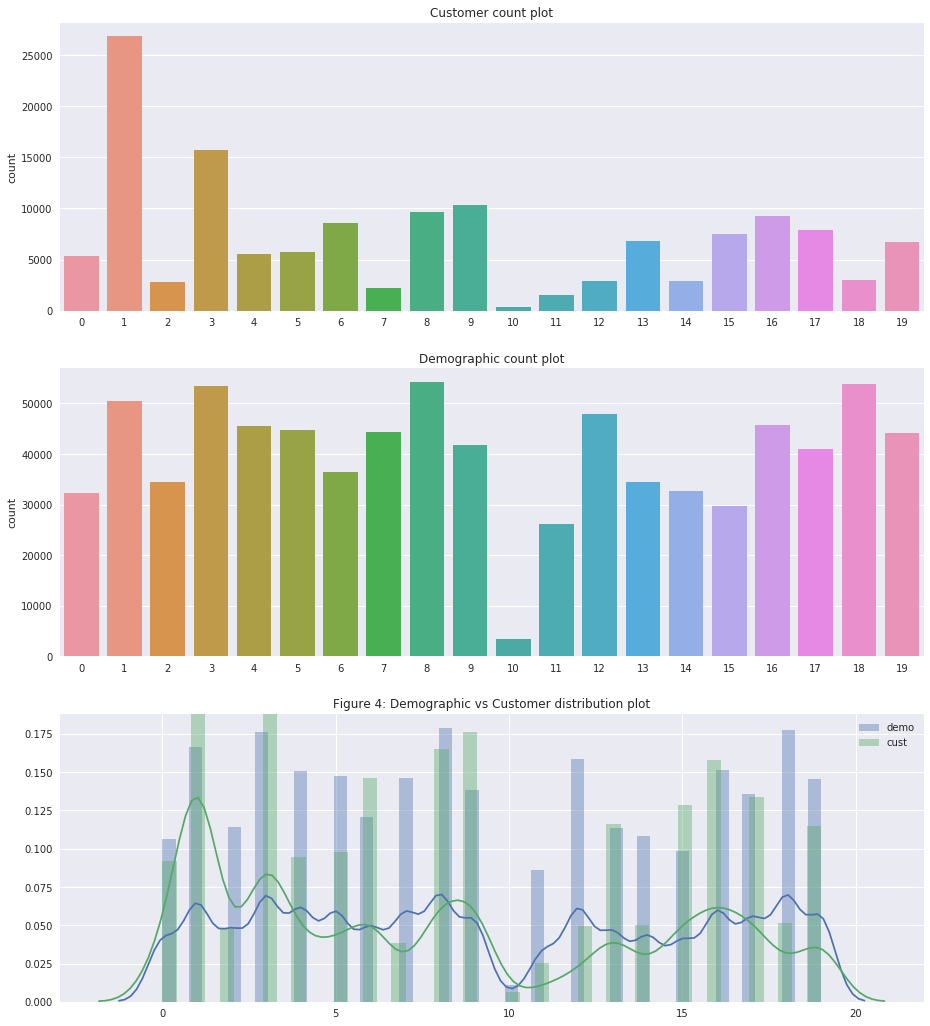

In [49]:
fig = plt.figure()
ax=fig.add_axes([0,0,2,1], title='Figure 4: Demographic vs Customer distribution plot')
ax2=fig.add_axes([0,1.2,2,1], title='Demographic count plot')
ax3=fig.add_axes([0,2.4,2,1], title='Customer count plot')
sns.set(style="darkgrid")
sns.distplot(clusters_pop, label='demo',ax=ax)
sns.distplot(clusters_cust, label='cust', ax=ax)
sns.countplot(clusters_pop, label='demo', ax=ax2)
sns.countplot(clusters_cust, label='cust', ax=ax3)
ax.legend();

In [50]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
cust_df = pd.DataFrame(clusters_cust,columns=['Cluster']).reset_index().groupby('Cluster').count()/len(clusters_cust)*100
pop_df = pd.DataFrame(clusters_pop,columns=['Cluster']).reset_index().groupby('Cluster').count()/len(clusters_pop)*100
diff = (cust_df-pop_df)
diff.rename_axis({'index':'DiffPerc'}, axis=1, inplace=True)
cust_df.rename_axis({'index':'CustPerc'}, axis=1, inplace=True)
pop_df.rename_axis({'index':'PopPerc'}, axis=1, inplace=True)
diff = diff.join(cust_df).join(pop_df).sort_values('DiffPerc',ascending=False)
diff.fillna(0, inplace=True)
diff

,DiffPerc,CustPerc,PopPerc
Cluster,,,
1,12.625840,18.956847,6.331007
3,4.412745,11.108835,6.696091
9,2.033584,7.280881,5.247297
15,1.582119,5.322410,3.740291
6,1.459800,6.037150,4.577349
16,0.774416,6.525178,5.750762
13,0.478736,4.799774,4.321038
17,0.390388,5.537820,5.147432
8,0.007077,6.815453,6.808376


In [51]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Cluster center specs can be found below:
cluster_specs = pd.DataFrame(scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_)), columns=azdias_missing_low.columns)
cluster_specs

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_MAINSTREAM,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
0,3.640513,0.965969,4.103818,1.170680,4.836614,0.891592,1.153616,3.314224,0.240727,2.222461,...,-0.035718,0.069000,0.008372,0.128496,0.128765,0.988883,65.724848,2.059382,4.653476,-0.644889
1,3.735620,0.885403,5.532124,0.935170,4.943243,0.793057,1.615180,1.568247,1.465092,1.814849,...,0.111776,0.107732,0.050545,0.051763,-0.039287,0.354278,33.109532,2.021870,2.296060,0.408868
2,2.780719,1.756460,3.412523,2.203630,3.801307,2.788320,2.920437,2.822321,0.496872,2.056306,...,0.161828,0.138791,0.048852,0.067336,0.004386,0.285564,58.812742,3.925621,2.504520,0.197489
3,3.864515,0.938634,5.576225,0.762897,5.162038,1.087625,1.187614,1.757347,0.228867,1.959821,...,0.142171,0.170749,0.071290,0.087234,-0.033597,0.330684,66.304929,1.651400,2.642129,0.274414
4,4.364282,1.690507,3.926335,0.724061,5.314934,0.877045,0.980249,4.123548,0.225694,1.570538,...,0.019976,0.084280,0.115902,0.069188,0.151792,0.648902,65.883639,1.101134,4.271465,-0.015106
5,3.993133,1.526618,4.221490,0.916215,5.067652,1.565591,1.188040,3.557972,0.324039,1.868743,...,0.117388,0.120702,0.114701,0.140620,0.033236,0.387576,63.456964,1.650364,3.369816,0.152438
6,3.113259,1.197332,4.941952,1.738886,3.936978,1.997054,2.506740,0.869352,0.307220,2.077875,...,0.191574,0.166149,0.066996,0.048249,-0.042208,0.360384,64.247703,3.552166,2.586683,0.181536
7,2.718903,1.783312,2.860333,2.441054,3.834187,2.809283,2.840724,3.714417,0.276936,1.937764,...,0.059344,0.104053,0.129296,0.108692,0.055653,0.521939,64.407868,3.869551,3.693244,-0.055096
8,3.826353,0.892433,4.385253,1.016963,5.085462,0.807074,1.209072,3.072853,0.221612,2.075344,...,0.024345,0.053868,0.098384,0.101883,0.168989,0.600920,66.379000,1.774318,4.281883,-0.283071
9,3.794404,1.215032,4.502801,0.835624,5.158542,0.577982,1.432005,3.358726,0.767765,1.861209,...,0.025808,0.270550,0.131384,0.175156,0.011112,0.420167,51.539661,1.670031,3.531545,0.182827


### Discussion 3.3: Compare Customer Data to Demographics Data

**Conclusion:** From Figure 4 on comparing the ratio of cluster 1, 3 and 9 are significantly higher in the customer data relative to the demographic/population data. These clusters have 46+ years of age, are male and have a high level of net income, likely to own a house and belong from West Germany.

* **Cluster 1:**
    * Represents the 46 years and above old Male Not a person with low financial interest Money saver Not a financial "be-prepared" type Owning a home Average social-minded Below-average family-minded Non-dreamful minded Non-sensual With highest estimated household net income From West Germany.
<br>
* **Cluster 3:**
    * Represents the 46 years and above old Male Not a person with low financial interest Money saver Not a financial "be-prepared" type Owning a home Average social-minded Below-average family-minded Non-dreamful minded Non-sensual Very high estimated household net income From West Germany.
<br>
* **Cluster 9:**
    * Represents the 46 years and above old Male Money saver Not a financial "be-prepared" type Average likelyhood of being a house owner Average family-minded Low dreamful minded Non-sensual Average/high estimated household net income From West Germany.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

In [53]:
!!jupyter nbconvert *.html

["[NbConvertApp] WARNING | pattern '*.html' matched no files",
 'This application is used to convert notebook files (*.ipynb) to various other',
 'formats.',
 '',
 'WARNING: THE COMMANDLINE INTERFACE MAY CHANGE IN FUTURE RELEASES.',
 '',
 'Options',
 '-------',
 '',
 'Arguments that take values are actually convenience aliases to full',
 'Configurables, whose aliases are listed on the help line. For more information',
 "on full configurables, see '--help-all'.",
 '',
 '--debug',
 '    set log level to logging.DEBUG (maximize logging output)',
 '--generate-config',
 '    generate default config file',
 '-y',
 '    Answer yes to any questions instead of prompting.',
 '--execute',
 '    Execute the notebook prior to export.',
 '--allow-errors',
 "    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.",
 '--stdin',
